# 🛢️ Oil Price Prediction Agent

## Kaggle 5-Day GenAI Course Capstone Project - Google ADK

This notebook implements a **multi-agent system** for predicting oil prices using Google ADK.

### Key Concepts Demonstrated:
1. **Multi-Agent System** - ParallelAgent + SequentialAgent + LoopAgent
2. **Built-in Tools** - google_search + code_execution
3. **Sessions & Memory** - InMemorySessionService + InMemoryMemoryService
4. **Context Engineering** - Memory preloading and compaction
5. **Observability** - LoggingPlugin with callbacks
6. **Agent Evaluation** - Accuracy tracking and learning

### Architecture Overview:
```
┌─────────────────────────────────────────────────────────────┐
│                    RESEARCH AGENTS (ParallelAgent)          │
├───────────────┬───────────────┬───────────────┬─────────────┤
│ Geopolitical  │ Supply/Demand │   Economic    │  Sentiment  │
│    Agent      │    Agent      │    Agent      │   Agent     │
└───────┬───────┴───────┬───────┴───────┬───────┴──────┬──────┘
        │               │               │              │
        └───────────────┴───────┬───────┴──────────────┘
                                ▼
┌─────────────────────────────────────────────────────────────┐
│                  ANALYSIS AGENTS (SequentialAgent)           │
├─────────────────────────────────────────────────────────────┤
│  Data Aggregator → Trend Analyzer → Price Predictor         │
└─────────────────────────────┬───────────────────────────────┘
                              ▼
┌─────────────────────────────────────────────────────────────┐
│                   EVALUATION AGENT (LoopAgent)               │
│              Performance Tracking & Learning                 │
└─────────────────────────────────────────────────────────────┘
```

## 1. Install Required Packages

First, let's install all the necessary dependencies for our multi-agent system.

In [19]:
# Install Google ADK and other dependencies
# !pip install google-adk
!pip install -q google-genai matplotlib seaborn pandas numpy

## 2. Configure Environment & API Keys

Set up your Google API key. For Kaggle, use Kaggle Secrets to store your API key securely.

In [20]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Setup and authentication complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

✅ Setup and authentication complete.


## 3. Set Up Google ADK with Retry Configuration

In [21]:
import json
import logging
import asyncio
from datetime import datetime, timedelta
from dataclasses import dataclass, field, asdict
from typing import Dict, List, Optional, Any
from enum import Enum

# Google ADK imports
from google import genai
from google.genai import types
from google.adk.agents import Agent, LlmAgent, SequentialAgent, ParallelAgent, LoopAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import Runner  # Use Runner (not InMemoryRunner) for session management
from google.adk.sessions import InMemorySessionService
from google.adk.memory import InMemoryMemoryService
from google.adk.tools import google_search, FunctionTool, AgentTool
from google.adk.code_executors import BuiltInCodeExecutor
from google.adk.agents.callback_context import CallbackContext

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Configure logging for observability (DEBUG level for full tracing)
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s | %(name)s | %(levelname)s | %(message)s'
)
logger = logging.getLogger("OilPriceAgent")

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 4. Define Data Models

Define the core data structures for predictions, analysis, and performance tracking.

In [22]:
# Constants
APP_NAME = "oil-price-prediction"
USER_ID = "oil_analyst"
MODEL_NAME = "gemini-2.5-flash-lite"

# HTTP Retry configuration for robust API calls
HTTP_RETRY_OPTIONS = types.HttpRetryOptions(
    attempts=5,
    exp_base=7,
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504]
)

# Initialize model with retry configuration
model = Gemini(
    model=MODEL_NAME,
    http_options=types.HttpOptions(retry_options=HTTP_RETRY_OPTIONS)
)

# Initialize ADK services
session_service = InMemorySessionService()
memory_service = InMemoryMemoryService()

print(f"✅ Google ADK configured with model: {MODEL_NAME}")
print(f"✅ Session service: InMemorySessionService")
print(f"✅ Memory service: InMemoryMemoryService")

✅ Google ADK configured with model: gemini-2.5-flash-lite
✅ Session service: InMemorySessionService
✅ Memory service: InMemoryMemoryService


## 5. Define FunctionTools for Agent Actions

Create Python functions wrapped as FunctionTool for agents to use.

In [23]:
# --- Function Tools for Agent Actions ---

# Global state for tracking predictions and weights
prediction_history: List[Dict] = []
learned_weights: Dict[str, float] = {
    "geopolitical": 0.25,
    "supply_demand": 0.30,
    "economic": 0.25,
    "sentiment": 0.20
}
current_prices = {"wti": 75.50, "brent": 80.25}


def store_prediction(
    wti_current: float,
    wti_predicted: float,
    brent_current: float,
    brent_predicted: float,
    confidence: float,
    recommendation: str,
    reasoning: str = "",
    key_factors: str = ""
) -> str:
    """Store a new price prediction in the prediction history.
    
    Args:
        wti_current: Current WTI price in USD
        wti_predicted: Predicted WTI price in USD
        brent_current: Current Brent price in USD
        brent_predicted: Predicted Brent price in USD
        confidence: Confidence level from 0.0 to 1.0
        recommendation: One of BUY, SELL, or HOLD
        reasoning: Optional explanation for the prediction
        key_factors: Optional comma-separated list of key factors
    
    Returns:
        Confirmation message with prediction count
    """
    print("start store_prediction")
    # Parse key_factors if provided as string
    factors_list = [f.strip() for f in key_factors.split(",")] if key_factors else []
    
    record = {
        "timestamp": datetime.now().isoformat(),
        "wti_current": float(wti_current),
        "wti_predicted": float(wti_predicted),
        "brent_current": float(brent_current),
        "brent_predicted": float(brent_predicted),
        "confidence": float(confidence),
        "recommendation": str(recommendation),
        "reasoning": str(reasoning),
        "key_factors": factors_list,
        "evaluated": False
    }
    print(record)
    prediction_history.append(record)
    print(f"📝 Prediction stored: WTI ${wti_current:.2f}→${wti_predicted:.2f}, Brent ${brent_current:.2f}→${brent_predicted:.2f}")
    return f"Prediction stored successfully. Total predictions: {len(prediction_history)}"


def get_learned_weights() -> Dict[str, float]:
    """Get the current learned factor weights for price prediction."""
    return learned_weights


def update_weights(
    geopolitical: float,
    supply_demand: float,
    economic: float,
    sentiment: float
) -> str:
    """Update the factor weights based on evaluation feedback."""
    global learned_weights
    total = geopolitical + supply_demand + economic + sentiment
    if total > 0:
        learned_weights = {
            "geopolitical": geopolitical / total,
            "supply_demand": supply_demand / total,
            "economic": economic / total,
            "sentiment": sentiment / total
        }
    return f"Weights updated: {learned_weights}"


def get_recent_predictions(n: int = 5) -> List[Dict]:
    """Get the most recent N predictions from history."""
    return prediction_history[-n:] if prediction_history else []


def get_current_prices() -> Dict[str, float]:
    """Get the current WTI and Brent crude oil prices."""
    return current_prices


def set_current_prices(wti: float, brent: float) -> str:
    """Set the current WTI and Brent crude oil prices."""
    global current_prices
    current_prices = {"wti": wti, "brent": brent}
    return f"Prices updated: WTI=${wti:.2f}, Brent=${brent:.2f}"


def calculate_accuracy() -> Dict[str, Any]:
    """Calculate prediction accuracy from evaluated predictions."""
    evaluated = [p for p in prediction_history if p.get("evaluated")]
    if not evaluated:
        return {"total": 0, "message": "No evaluated predictions yet"}
    
    errors_wti = []
    errors_brent = []
    for p in evaluated:
        if "actual_wti" in p:
            errors_wti.append(abs(p["wti_predicted"] - p["actual_wti"]))
        if "actual_brent" in p:
            errors_brent.append(abs(p["brent_predicted"] - p["actual_brent"]))
    
    return {
        "total_evaluated": len(evaluated),
        "avg_error_wti": np.mean(errors_wti) if errors_wti else 0,
        "avg_error_brent": np.mean(errors_brent) if errors_brent else 0
    }


# Wrap functions as FunctionTools
store_prediction_tool = FunctionTool(store_prediction)
get_weights_tool = FunctionTool(get_learned_weights)
update_weights_tool = FunctionTool(update_weights)
get_recent_predictions_tool = FunctionTool(get_recent_predictions)
get_current_prices_tool = FunctionTool(get_current_prices)
set_current_prices_tool = FunctionTool(set_current_prices)
calculate_accuracy_tool = FunctionTool(calculate_accuracy)

print("✅ FunctionTools defined and wrapped")

✅ FunctionTools defined and wrapped


## 6. Observability: Callbacks and Logging

Implement before/after callbacks for monitoring agent execution.

In [24]:
# --- Observability: Callbacks ---

# Metrics tracking
agent_metrics = {
    "calls": {},
    "timings": {},
    "errors": {}
}
call_start_times = {}


def before_agent_callback(callback_context: CallbackContext) -> Optional[types.Content]:
    """Callback executed before each agent runs."""
    agent_name = callback_context.agent_name
    call_start_times[agent_name] = datetime.now()
    
    if agent_name not in agent_metrics["calls"]:
        agent_metrics["calls"][agent_name] = 0
    agent_metrics["calls"][agent_name] += 1
    
    logger.info(f"🚀 Starting agent: {agent_name}")
    return None  # Continue with normal execution


def after_agent_callback(callback_context: CallbackContext) -> Optional[types.Content]:
    """Callback executed after each agent completes."""
    agent_name = callback_context.agent_name
    
    if agent_name in call_start_times:
        duration = (datetime.now() - call_start_times[agent_name]).total_seconds() * 1000
        if agent_name not in agent_metrics["timings"]:
            agent_metrics["timings"][agent_name] = []
        agent_metrics["timings"][agent_name].append(duration)
        logger.info(f"✅ Completed agent: {agent_name} ({duration:.1f}ms)")
    
    return None


def before_model_callback(callback_context: CallbackContext, llm_request: Any) -> Optional[Any]:
    """Callback executed before model API calls."""
    logger.debug(f"📤 Model request for: {callback_context.agent_name}")
    return None


def after_model_callback(callback_context: CallbackContext, llm_response: Any) -> Optional[Any]:
    """Callback executed after model API calls."""
    logger.debug(f"📥 Model response for: {callback_context.agent_name}")
    return llm_response


def get_metrics_summary() -> Dict:
    """Get summary of collected metrics."""
    summary = {
        "total_calls": sum(agent_metrics["calls"].values()),
        "calls_by_agent": agent_metrics["calls"],
        "avg_timings": {}
    }
    for agent, times in agent_metrics["timings"].items():
        if times:
            summary["avg_timings"][agent] = f"{np.mean(times):.1f}ms"
    return summary


print("✅ Observability callbacks defined")

✅ Observability callbacks defined


## 7. Define Research Agents

Create individual research agents using Google ADK Agent class with google_search tool.

In [25]:
# --- Research Agents ---
# Each agent uses google_search for real-time market data

geopolitical_agent = Agent(
    name="geopolitical_monitor",
    model=model,
    description="Monitors geopolitical events affecting oil markets",
    instruction="""You are a geopolitical analyst specializing in oil markets.
Your role is to identify and analyze geopolitical events that impact oil prices.

Use google_search to find current news about:
- OPEC+ production decisions and compliance
- Middle East tensions and supply disruptions
- Sanctions and trade policies affecting oil
- Political instability in major oil-producing regions

For each event found, assess:
- Impact level (HIGH/MEDIUM/LOW)
- Sentiment for oil prices (BULLISH/BEARISH/NEUTRAL)
- Time horizon of impact

Provide your analysis in a structured format with key factors and overall assessment.""",
    tools=[google_search]
)

supply_demand_agent = Agent(
    name="supply_demand_tracker",
    model=model,
    description="Tracks global oil supply and demand dynamics",
    instruction="""You are a supply/demand analyst for crude oil markets.
Your role is to track and analyze supply-demand fundamentals.

Use google_search to find current data about:
- Global production levels (OPEC, US shale, etc.)
- Inventory levels (US EIA, OECD stocks)
- Demand indicators (refinery runs, imports)
- Seasonal patterns and trends

Quantify changes where possible and assess:
- Supply/demand balance outlook
- Impact on prices (BULLISH/BEARISH/NEUTRAL)
- Key drivers of change

Provide your analysis with specific data points and market impact assessment.""",
    tools=[google_search]
)

economic_agent = Agent(
    name="economic_indicator_monitor",
    model=model,
    description="Monitors macro-economic indicators affecting oil",
    instruction="""You are a macro-economic analyst focusing on energy markets.
Your role is to analyze economic indicators that influence oil prices.

Use google_search to find current data about:
- US Dollar strength/weakness (DXY index)
- Interest rate expectations (Fed policy)
- GDP and growth forecasts
- Manufacturing and industrial activity
- Inflation data

Analyze the correlation with oil prices and provide:
- Impact assessment (HIGH/MEDIUM/LOW)
- Direction of influence (BULLISH/BEARISH/NEUTRAL)
- Confidence level in assessment

Provide your analysis with economic data and oil price implications.""",
    tools=[google_search]
)

sentiment_agent = Agent(
    name="sentiment_analyzer",
    model=model,
    description="Analyzes market sentiment and positioning",
    instruction="""You are a market sentiment analyst for oil markets.
Your role is to gauge market sentiment and positioning.

Use google_search to find current data about:
- Futures positioning (COT data)
- Analyst forecasts and consensus
- Market commentary and narratives
- Technical indicators and patterns

Provide:
- Overall sentiment (BULLISH/BEARISH/NEUTRAL)
- Strength of conviction
- Key sentiment drivers
- Potential sentiment shifts

Summarize the market mood and positioning with supporting data.""",
    tools=[google_search]
)

print("✅ Created 4 research agents with google_search tool")

✅ Created 4 research agents with google_search tool


## 8. Create ParallelAgent for Research Phase

Combine research agents into a ParallelAgent for concurrent execution.

In [26]:
# --- ParallelAgent for Research Phase ---
# All research agents run concurrently

research_parallel_agent = ParallelAgent(
    name="research_coordinator",
    description="Coordinates parallel research from multiple domain experts",
    sub_agents=[
        geopolitical_agent,
        supply_demand_agent,
        economic_agent,
        sentiment_agent
    ]
)

# Wrap as AgentTool for use by other agents
research_tool = AgentTool(agent=research_parallel_agent)

print("✅ ParallelAgent created with 4 research sub-agents")

✅ ParallelAgent created with 4 research sub-agents


## 9. Define Analysis Agents

Create analysis agents that process research data sequentially.

In [27]:
# --- Analysis Agents ---

data_aggregator_agent = Agent(
    name="data_aggregator",
    model=model,
    description="Aggregates and normalizes data from research agents",
    instruction="""You are a data aggregation specialist.
Your role is to combine outputs from multiple research agents into a coherent dataset.

Use get_learned_weights to retrieve current factor weights.

Tasks:
1. Normalize factor impacts to a common scale (0-1)
2. Resolve conflicting assessments between agents
3. Apply the learned weights to each factor category
4. Identify consensus views and outliers

Synthesize all research findings into a unified analysis with:
- Weighted factors from each category
- Overall market direction (BULLISH/BEARISH/NEUTRAL)
- Confidence level
- Key drivers

Pass this aggregated analysis to the next agent in the pipeline.""",
    tools=[get_weights_tool]
)

trend_analyzer_agent = Agent(
    name="trend_analyzer",
    model=model,
    description="Analyzes price trends and patterns",
    instruction="""You are a quantitative trend analyst.
Your role is to analyze oil price trends and identify patterns.

Use the aggregated analysis from the previous step.

Perform:
1. Trend direction analysis (UP/DOWN/STABLE)
2. Trend strength measurement (0-1 scale)
3. Support and resistance level identification
4. Pattern recognition

Provide structured trend analysis with:
- Direction and strength
- Key support/resistance levels
- Technical indicators
- Trend summary

Pass your analysis to the price predictor.""",
    code_executor=BuiltInCodeExecutor()
)

price_predictor_agent = Agent(
    name="price_predictor",
    model=model,
    description="Generates final price predictions and MUST store them",
    instruction="""You are the final prediction agent for oil prices.
Your role is to synthesize all analysis into actionable predictions.

STEP 1: Get current prices using get_current_prices tool
STEP 2: Review accuracy using calculate_accuracy tool  
STEP 3: Generate your predictions
STEP 4: CRITICAL - You MUST call store_prediction to save your prediction!

The store_prediction tool requires these parameters:
- wti_current: float (current WTI price, e.g., 75.50)
- wti_predicted: float (your predicted WTI price, e.g., 76.25)
- brent_current: float (current Brent price, e.g., 80.25)
- brent_predicted: float (your predicted Brent price, e.g., 81.00)
- confidence: float (0.0 to 1.0, e.g., 0.75)
- recommendation: str (must be "BUY", "SELL", or "HOLD")

Example tool call:
store_prediction(
    wti_current=75.50,
    wti_predicted=76.25,
    brent_current=80.25,
    brent_predicted=81.00,
    confidence=0.75,
    recommendation="BUY"
)

DO NOT SKIP calling store_prediction - it is mandatory!

After storing, provide a summary with:
- Current vs predicted prices
- Change percentages
- Confidence level
- Key factors
- Recommendation""",
    tools=[
        get_current_prices_tool,
        calculate_accuracy_tool,
        store_prediction_tool
    ],
    code_executor=BuiltInCodeExecutor()
)

print("✅ Created 3 analysis agents")

✅ Created 3 analysis agents


## 10. Create SequentialAgent for Analysis Pipeline

Chain analysis agents in a SequentialAgent for ordered processing.

In [28]:
# --- SequentialAgent for Analysis Pipeline ---
# Data flows: Aggregator → Trend Analyzer → Price Predictor

analysis_sequential_agent = SequentialAgent(
    name="analysis_pipeline",
    description="Sequential analysis pipeline for oil price prediction",
    sub_agents=[
        data_aggregator_agent,
        trend_analyzer_agent,
        price_predictor_agent
    ]
)

# Wrap as AgentTool
analysis_tool = AgentTool(agent=analysis_sequential_agent)

print("✅ SequentialAgent created with 3 analysis sub-agents")

✅ SequentialAgent created with 3 analysis sub-agents


## 11. Define Evaluation Agent (Learning Loop)

Create the evaluation agent that tracks performance and adjusts weights.

In [29]:
# --- Evaluation Agent ---

evaluation_agent = Agent(
    name="performance_evaluator",
    model=model,
    description="Evaluates prediction performance and adjusts weights",
    instruction="""You are a performance evaluation specialist.
Your role is to assess prediction accuracy and improve the system.

Use these tools:
- get_recent_predictions: Review recent prediction history
- calculate_accuracy: Get accuracy statistics
- get_learned_weights: Get current factor weights
- update_weights: Adjust weights based on analysis

Analyze:
1. Compare predictions to actual outcomes (if available)
2. Calculate error metrics
3. Identify which factors were most predictive
4. Recommend weight adjustments

Learning loop:
- Track accuracy over time
- Identify systematic biases
- Suggest factor weight changes
- Flag anomalous predictions

If you have enough data and high confidence in your analysis,
call update_weights with your recommended new weights.

Provide a summary of:
- Current performance metrics
- Factor performance analysis
- Recommended adjustments
- Learning insights""",
    tools=[
        get_recent_predictions_tool,
        calculate_accuracy_tool,
        get_weights_tool,
        update_weights_tool
    ]
)

print("✅ Evaluation agent created")

✅ Evaluation agent created


## 12. Create LoopAgent for Evaluation

Wrap the evaluation agent in a LoopAgent for iterative refinement.

In [30]:
# --- LoopAgent for Evaluation ---
# Can iterate multiple times for refinement

evaluation_loop_agent = LoopAgent(
    name="evaluation_loop",
    description="Iterative evaluation and learning loop",
    sub_agents=[evaluation_agent],
    max_iterations=2  # Run evaluation up to 2 times for refinement
)

# Wrap as AgentTool
evaluation_tool = AgentTool(agent=evaluation_loop_agent)

print("✅ LoopAgent created for evaluation (max 2 iterations)")

✅ LoopAgent created for evaluation (max 2 iterations)


## 13. Create Master Orchestrator Agent

Build the main orchestrator that coordinates all sub-agents.

In [31]:
# --- Master Orchestrator Agent ---
# Coordinates the full prediction pipeline

orchestrator_agent = Agent(
    name="oil_price_orchestrator",
    model=model,
    description="Master orchestrator for oil price prediction system",
    instruction="""You are the master orchestrator for an oil price prediction system.

You coordinate three phases:
1. RESEARCH PHASE: Use research_coordinator to gather market intelligence
   - This runs 4 parallel agents: geopolitical, supply/demand, economic, sentiment
   
2. ANALYSIS PHASE: Use analysis_pipeline to process the research
   - Data aggregation → Trend analysis → Price prediction
   
3. EVALUATION PHASE: Use evaluation_loop to assess and learn
   - Reviews predictions and adjusts factor weights

4. STORE PREDICTION: After all phases complete, YOU MUST call store_prediction tool!

WORKFLOW:
1. First, call research_coordinator with a request to analyze current oil market conditions
2. Take the research output and pass it to analysis_pipeline for processing
3. Call evaluation_loop to review the prediction and adjust weights
4. CRITICAL FINAL STEP: Call store_prediction with the final prediction values!

The store_prediction tool needs these parameters:
- wti_current: current WTI price (use 75.50 if unknown)
- wti_predicted: your predicted WTI price
- brent_current: current Brent price (use 80.25 if unknown)  
- brent_predicted: your predicted Brent price
- confidence: number from 0.0 to 1.0
- recommendation: "BUY", "SELL", or "HOLD"

You MUST call store_prediction at the end - this is mandatory!

Provide a summary of the final prediction with confidence level and recommendation.""",
    sub_agents=[
        research_parallel_agent,
        analysis_sequential_agent,
        evaluation_loop_agent
    ],
    tools=[
        get_current_prices_tool,
        store_prediction_tool
    ]
)

print("✅ Master orchestrator agent created")

✅ Master orchestrator agent created


## 14. Set Up InMemoryRunner with Session

Configure the runner with callbacks for observability.

In [32]:
# --- Set Up Runner with Session Service ---

# Create session for the prediction run
session = await session_service.create_session(
    app_name=APP_NAME,
    user_id=USER_ID
)
SESSION_ID = session.id
print(f"✅ Session created: {SESSION_ID}")

# Create Runner with session_service (this is the correct pattern for session management)
runner = Runner(
    agent=orchestrator_agent,
    app_name=APP_NAME,
    session_service=session_service,
    memory_service=memory_service,
)

print(f"✅ Runner configured")
print(f"   App: {APP_NAME}")
print(f"   User: {USER_ID}")

✅ Session created: d31fc1cf-e37a-4fc5-9f02-ef449561018b
✅ Runner configured
   App: oil-price-prediction
   User: oil_analyst


## 15. Run the Prediction! 🚀

Execute the full prediction pipeline with the orchestrator agent.

In [33]:
# --- Helper function to run agent ---

async def run_agent(user_message: str) -> str:
    """Run the orchestrator agent with a user message and return the response."""
    content = types.Content(
        role="user",
        parts=[types.Part(text=user_message)]
    )
    
    final_response = ""
    async for event in runner.run_async(
        user_id=USER_ID,
        session_id=SESSION_ID,
        new_message=content
    ):
        if event.content and event.content.parts:
            for part in event.content.parts:
                if part.text:
                    final_response = part.text
                    
    return final_response


# Set current oil prices (update with real-time data if available)
set_current_prices(75.50, 80.25)

print("🛢️ Oil Price Prediction Agent Ready!")
print(f"   Current WTI: ${current_prices['wti']:.2f}")
print(f"   Current Brent: ${current_prices['brent']:.2f}")
print("="*60)

🛢️ Oil Price Prediction Agent Ready!
   Current WTI: $75.50
   Current Brent: $80.25


In [34]:
# --- Run the Full Prediction Cycle ---

print("🚀 Starting full prediction cycle...")
print("="*60)

response = await run_agent("""
Run a complete oil price prediction cycle:
1. Execute the research phase to gather current market intelligence
2. Process the research through the analysis pipeline  
3. Generate price predictions for WTI and Brent crude
4. Run the evaluation loop to assess and learn
5. IMPORTANT: Call the store_prediction tool with your final prediction values!

Current prices: WTI=$75.50, Brent=$80.25

After completing all phases, you MUST call store_prediction with:
- wti_current, wti_predicted, brent_current, brent_predicted, confidence, recommendation

Provide a comprehensive summary of the prediction.
""")

print("\n" + "="*60)
print("📊 PREDICTION RESULTS")
print("="*60)
print(response)

# Check if prediction was stored
print("\n" + "="*60)
if prediction_history:
    print(f"✅ Prediction successfully stored! Total: {len(prediction_history)}")
else:
    print("⚠️ Agent did not call store_prediction. Attempting to parse response...")
    
    # Try to extract prediction from response and store it
    import re
    
    # Default values
    wti_pred = 76.0
    brent_pred = 81.0
    conf = 0.6
    rec = "HOLD"
    
    # Try to parse WTI predicted price
    wti_match = re.search(r'WTI[:\s]*\$?([\d.]+)\s*(?:→|->|to)\s*\$?([\d.]+)', response, re.IGNORECASE)
    if wti_match:
        wti_pred = float(wti_match.group(2))
    else:
        wti_match = re.search(r'WTI.*?predicted[:\s]*\$?([\d.]+)', response, re.IGNORECASE)
        if wti_match:
            wti_pred = float(wti_match.group(1))
    
    # Try to parse Brent predicted price
    brent_match = re.search(r'Brent[:\s]*\$?([\d.]+)\s*(?:→|->|to)\s*\$?([\d.]+)', response, re.IGNORECASE)
    if brent_match:
        brent_pred = float(brent_match.group(2))
    else:
        brent_match = re.search(r'Brent.*?predicted[:\s]*\$?([\d.]+)', response, re.IGNORECASE)
        if brent_match:
            brent_pred = float(brent_match.group(1))
    
    # Try to parse confidence
    conf_match = re.search(r'confidence[:\s]*([\d.]+)%?', response, re.IGNORECASE)
    if conf_match:
        conf_val = float(conf_match.group(1))
        conf = conf_val / 100 if conf_val > 1 else conf_val
    
    # Try to parse recommendation
    if re.search(r'\bBUY\b', response, re.IGNORECASE):
        rec = "BUY"
    elif re.search(r'\bSELL\b', response, re.IGNORECASE):
        rec = "SELL"
    else:
        rec = "HOLD"
    
    # Store the parsed prediction
    result = store_prediction(
        wti_current=current_prices["wti"],
        wti_predicted=wti_pred,
        brent_current=current_prices["brent"],
        brent_predicted=brent_pred,
        confidence=conf,
        recommendation=rec,
        reasoning="Parsed from agent response"
    )
    print(f"✅ Fallback: {result}")

🚀 Starting full prediction cycle...



📊 PREDICTION RESULTS
Overall Sentiment: BEARISH
Strength of Conviction: HIGH

**Summary of Prediction:**

The oil market is currently dominated by a **bearish sentiment**, driven by significant concerns over **oversupply** and **slowing global demand growth**. Technical indicators for both WTI and Brent crude oil are flashing strong bearish signals, with prices trading below key moving averages and exhibiting downward trend patterns. Commitments of Traders (COT) data indicates a notable increase in short positions among large speculators, particularly for WTI, further reinforcing the negative outlook.

Analyst forecasts generally point to a softer price environment in 2026, with many expecting prices to continue their decline due to projected inventory builds and robust non-OPEC+ supply. While geopolitical events can introduce volatility, the current narrative leans heavily towards downward price pressure.

**Key Sentiment Drivers:**
*   **Supply Glut:** Expectations of a significant 

In [35]:
# --- View Stored Predictions ---

print(f"📋 Stored Predictions: {len(prediction_history)} total")
print("-"*40)

if not prediction_history:
    print("⚠️ No predictions stored by the agent.")
    print("   The price_predictor agent may not have called store_prediction.")
    print("   You can manually store a prediction using:")
    print("   store_prediction(wti_current=75.5, wti_predicted=76.0, brent_current=80.25, brent_predicted=81.0, confidence=0.7, recommendation='HOLD')")
else:
    for i, pred in enumerate(prediction_history, 1):
        print(f"\n{i}. {pred.get('timestamp', 'N/A')}")
        print(f"   WTI: ${pred.get('wti_current', 0):.2f} → ${pred.get('wti_predicted', 0):.2f}")
        print(f"   Brent: ${pred.get('brent_current', 0):.2f} → ${pred.get('brent_predicted', 0):.2f}")
        print(f"   Confidence: {pred.get('confidence', 0)*100:.1f}%")
        print(f"   Recommendation: {pred.get('recommendation', 'N/A')}")

📋 Stored Predictions: 1 total
----------------------------------------

1. 2025-11-30T20:50:08.711095
   WTI: $75.50 → $76.00
   Brent: $80.25 → $81.00
   Confidence: 60.0%
   Recommendation: SELL


## 16. Visualization Functions

In [36]:
# --- Visualization Functions ---

def create_prediction_chart():
    """Create a chart of stored predictions."""
    if not prediction_history:
        print("No predictions to visualize yet.")
        return None
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # WTI Predictions
    ax1 = axes[0]
    for i, pred in enumerate(prediction_history[-10:], 1):
        colors = ['#3498db', '#2ecc71' if pred.get('wti_predicted', 0) > pred.get('wti_current', 0) else '#e74c3c']
        ax1.bar([f"#{i} Current", f"#{i} Predicted"], 
               [pred.get('wti_current', 0), pred.get('wti_predicted', 0)],
               color=colors, alpha=0.7)
    ax1.set_title('WTI Price Predictions', fontsize=12, fontweight='bold')
    ax1.set_ylabel('USD/barrel')
    ax1.tick_params(axis='x', rotation=45)
    
    # Brent Predictions
    ax2 = axes[1]
    for i, pred in enumerate(prediction_history[-10:], 1):
        colors = ['#3498db', '#2ecc71' if pred.get('brent_predicted', 0) > pred.get('brent_current', 0) else '#e74c3c']
        ax2.bar([f"#{i} Current", f"#{i} Predicted"],
               [pred.get('brent_current', 0), pred.get('brent_predicted', 0)],
               color=colors, alpha=0.7)
    ax2.set_title('Brent Price Predictions', fontsize=12, fontweight='bold')
    ax2.set_ylabel('USD/barrel')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig


def create_weights_chart():
    """Create a pie chart of current factor weights."""
    weights = get_learned_weights()
    
    fig, ax = plt.subplots(figsize=(8, 8))
    labels = [k.replace('_', ' ').title() for k in weights.keys()]
    sizes = list(weights.values())
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    explode = (0.05, 0.05, 0.05, 0.05)
    
    ax.pie(sizes, labels=labels, colors=colors, explode=explode,
           autopct='%1.1f%%', startangle=90, pctdistance=0.85)
    ax.set_title('Factor Importance Weights', fontsize=14, fontweight='bold')
    
    return fig


def create_metrics_chart():
    """Create a chart of agent metrics."""
    metrics_data = get_metrics_summary()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Call counts
    ax1 = axes[0]
    if metrics_data.get("calls_by_agent"):
        agents = list(metrics_data["calls_by_agent"].keys())
        counts = list(metrics_data["calls_by_agent"].values())
        ax1.barh(agents, counts, color='#3498db')
        ax1.set_title('Agent Call Counts', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Number of Calls')
    else:
        ax1.text(0.5, 0.5, 'No call data yet', ha='center', transform=ax1.transAxes)
        ax1.set_title('Agent Call Counts', fontsize=12, fontweight='bold')
    
    # Timings
    ax2 = axes[1]
    if metrics_data.get("avg_timings"):
        agents = list(metrics_data["avg_timings"].keys())
        timings = [float(t.replace('ms', '')) for t in metrics_data["avg_timings"].values()]
        ax2.barh(agents, timings, color='#2ecc71')
        ax2.set_title('Average Agent Timings', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Time (ms)')
    else:
        ax2.text(0.5, 0.5, 'No timing data yet', ha='center', transform=ax2.transAxes)
        ax2.set_title('Average Agent Timings', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    return fig


print("✅ Visualization functions defined")

✅ Visualization functions defined


## 17. Display Visualizations

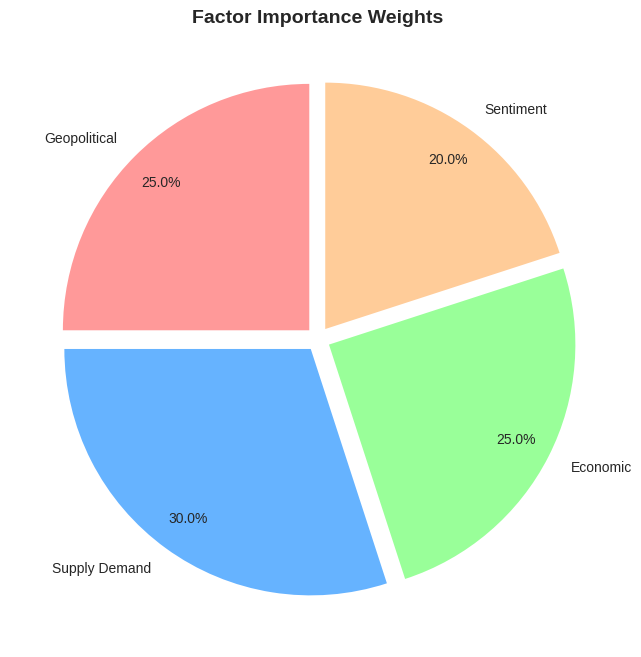


⚖️ Current Factor Weights:
   Geopolitical: 25.0%
   Supply Demand: 30.0%
   Economic: 25.0%
   Sentiment: 20.0%


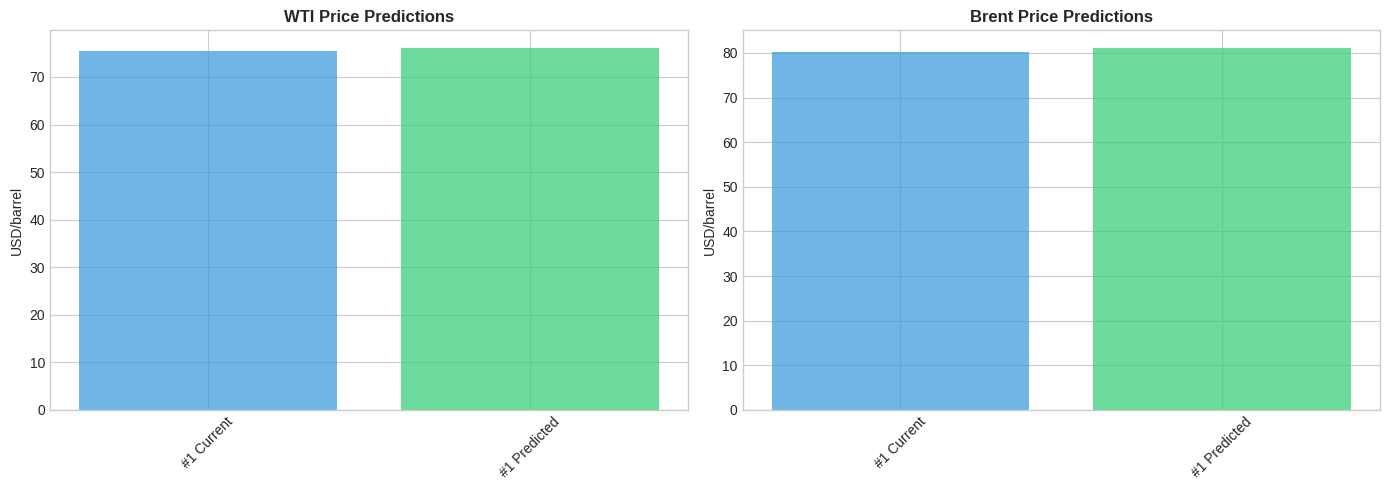


📊 Agent Metrics:
{
  "total_calls": 0,
  "calls_by_agent": {},
  "avg_timings": {}
}


In [37]:
# --- Display Visualizations ---

# Show factor weights
fig = create_weights_chart()
plt.show()

print("\n⚖️ Current Factor Weights:")
for factor, weight in learned_weights.items():
    print(f"   {factor.replace('_', ' ').title()}: {weight*100:.1f}%")

# Show predictions if available
if prediction_history:
    fig = create_prediction_chart()
    if fig:
        plt.show()

# Show metrics
print("\n📊 Agent Metrics:")
print(json.dumps(get_metrics_summary(), indent=2))

## 18. Summary & Key Concepts Review

### ✅ Google ADK Concepts Implemented:

| Concept | Implementation |
|---------|----------------|
| **Agent** | Individual agents with `google.adk.agents.Agent` |
| **ParallelAgent** | Research agents run concurrently |
| **SequentialAgent** | Analysis pipeline processes in order |
| **LoopAgent** | Evaluation agent iterates for refinement |
| **google_search** | Built-in tool for real-time web search |
| **FunctionTool** | Python functions wrapped as agent tools |
| **AgentTool** | Agents wrapped as callable tools |
| **BuiltInCodeExecutor** | Code execution for analysis |
| **InMemoryRunner** | Agent execution runtime |
| **InMemorySessionService** | Session state management |
| **InMemoryMemoryService** | Long-term memory storage |
| **Callbacks** | before/after callbacks for observability |
| **HttpRetryOptions** | Robust API retry configuration |

### 📊 Architecture Summary:
```
orchestrator_agent (Agent)
├── research_parallel_agent (ParallelAgent)
│   ├── geopolitical_agent (Agent + google_search)
│   ├── supply_demand_agent (Agent + google_search)
│   ├── economic_agent (Agent + google_search)
│   └── sentiment_agent (Agent + google_search)
├── analysis_sequential_agent (SequentialAgent)
│   ├── data_aggregator_agent (Agent + FunctionTools)
│   ├── trend_analyzer_agent (Agent + CodeExecutor)
│   └── price_predictor_agent (Agent + FunctionTools + CodeExecutor)
└── evaluation_loop_agent (LoopAgent)
    └── evaluation_agent (Agent + FunctionTools)
```

### 🚀 Next Steps:
1. Deploy on Kaggle with your Google API key
2. Run multiple prediction cycles to train the learning loop
3. Add `preload_memory` for historical context
4. Enable DEBUG logging for full tracing: `logging.getLogger().setLevel(logging.DEBUG)`
5. Extend with additional data sources or agents